---
title: "filtering 1"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: false
    code-summary: "Show the code"
---

Download <a href="shani_temperature.csv" download>this csv</a> file before you start. It contains the dataset used in this notebook.

  
In this practice we will filter frequencies in our data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
import concurrent.futures
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import math
import scipy
from scipy.signal import find_peaks

# %matplotlib widget

Import data

In [2]:
df = pd.read_csv('shani_temperature.csv', index_col='datetime', parse_dates=True)
df

,T
datetime,
2000-01-01 00:00:00,16.791667
2000-01-01 02:00:00,16.975000
2000-01-01 04:00:00,16.825000
2000-01-01 06:00:00,17.050000
2000-01-01 08:00:00,19.900000
...,...
2020-12-31 14:00:00,17.341667
2020-12-31 16:00:00,14.900000
2020-12-31 18:00:00,13.308333


plot

<AxesSubplot:xlabel='datetime'>

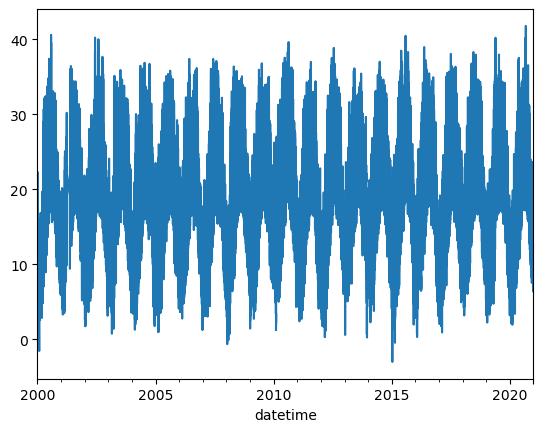

In [3]:
df['T'].plot()

### Apply FFT

In [4]:
dt = 2 # 2hr interval is like 1/12 of a day
N = len(df)
t = np.arange(0,int(len(df)),dt)
x = df['T'].values
# standardize x:
x = (x - np.mean(x))/np.std(x)

In [5]:
fft = scipy.fft.fft(x) / N
k = scipy.fft.fftfreq(N, dt)
fft_abs = np.abs(fft)

Keep only positive k values

In [6]:
fft_abs = fft_abs[k>=0]
k = k[k>=0]

In [7]:
peaks, _ = find_peaks(fft_abs, threshold=0.05)

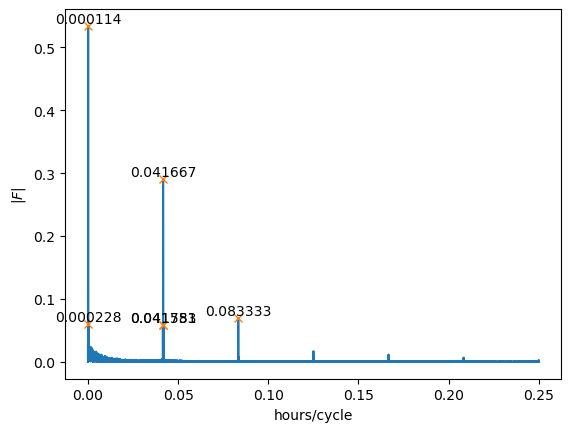

In [8]:
np.seterr(divide='ignore')

fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="hours/cycle",
       ylabel=r"$|F|$")
ax.plot(k[peaks], fft_abs[peaks], "x")
# ax.set_xscale('log')
# ax.set_xlim(-50,450)
for peak in peaks:
    ax.text(k[peak], fft_abs[peak], f'{k[peak]:.6f}', ha='center', va='bottom')
None
# print(1/k[peaks])

## filtering
By transforming our signal into an array of frequencies, each with its own weight, we've prepared it for manipulation. This array represents the composite frequencies that construct our original signal. Through manipulation—specifically, filtering—we can adjust the weights of these frequencies, often zeroing some out. Filtering allows us to modify the original signal in a controlled manner.


In [9]:
def fft_filter(array, condition):
    # this function recieves 2 arguments:
    #  array - np array of the timeseries that needs filtering
    # condition - np array of a mask of boolean values 
    # true values will be kept and false values will be set to 0
    
    # FFT the signal
    sig_fft = scipy.fft.fft(array)

    # copy the FFT results
    sig_fft_filtered = sig_fft.copy()
    sig_fft_filtered[~condition] = 0

    # get the filtered signal in time domain
    filtered = scipy.fft.ifft(sig_fft_filtered) 
    return filtered


In [10]:
x = df['T'].values
freq = scipy.fft.fftfreq(N, dt)

## low-pass filter

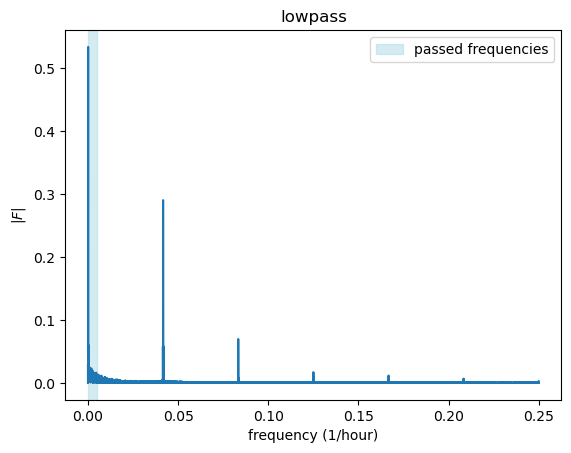

In [11]:
cut_off = 0.005

fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="frequency (1/hour)",
       ylabel=r"$|F|$",
       title=r"lowpass")


ax.axvspan(0, cut_off, color='lightblue', alpha=0.5, label='passed frequencies')
ax.legend()

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


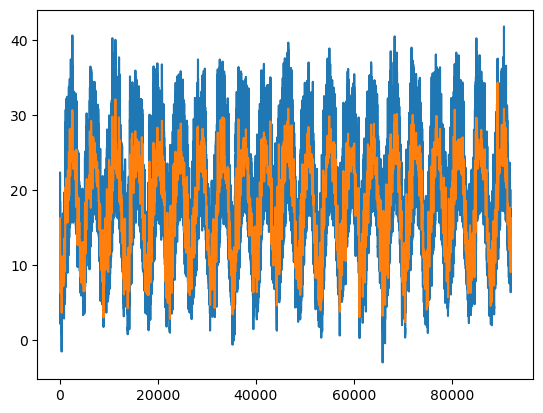

In [12]:
fig, ax = plt.subplots()
ax.plot(x)
condition = np.abs(freq) < cut_off
ax.plot(fft_filter(x, condition))

By applying a lowpass filter we removed the high frequency daily signal while keeping the low frequency signal of the yearly oscillation.

## high-pass filter

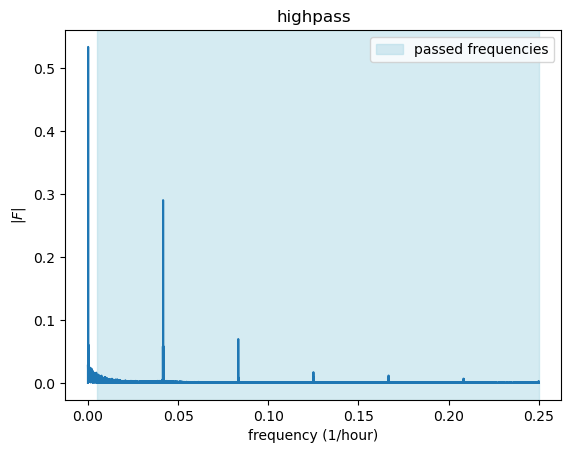

In [13]:
cut_off = 0.005

fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="frequency (1/hour)",
       ylabel=r"$|F|$",
       title=r"highpass")

# ax.axvspan(0, cut_off, color='lightblue', alpha=0.5)
ax.axvspan(cut_off, np.max(k), color='lightblue', alpha=0.5, label='passed frequencies')
ax.legend()

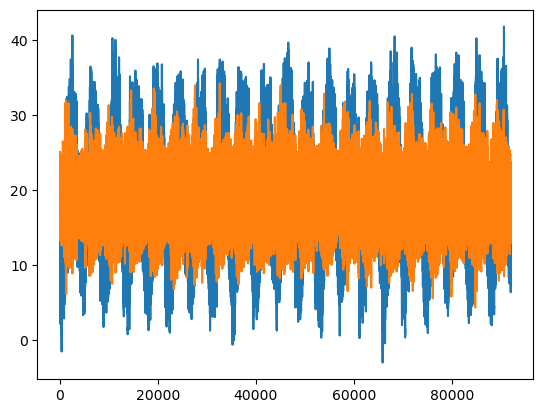

In [14]:
fig, ax = plt.subplots()
ax.plot(x)
condition = np.abs(freq) > cut_off
ax.plot(fft_filter(x, condition) + np.mean(x))

By applying a highpass filter we removed the low frequency signal of the yearly oscillation while keeping the high frequency daily signal

## band-pass filter

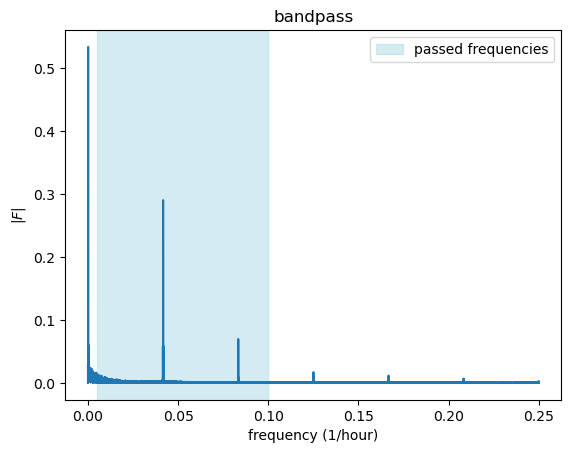

In [15]:
low_thresh = 0.005
high_thresh = 0.1

fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="frequency (1/hour)",
       ylabel=r"$|F|$",
       title=r"bandpass")

ax.axvspan(low_thresh, high_thresh, color='lightblue', alpha=0.5, label='passed frequencies')
ax.legend()

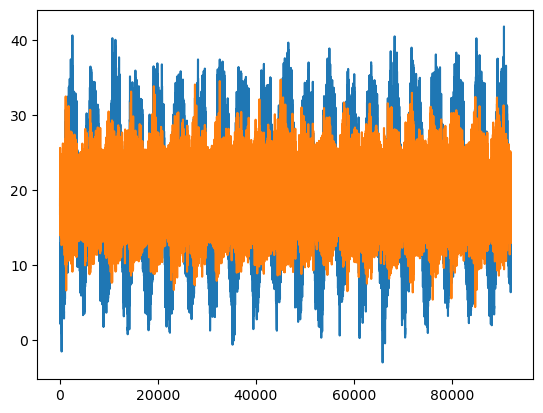

In [16]:
fig, ax = plt.subplots()
ax.plot(x)
condition = (np.abs(freq) > low_thresh) & (np.abs(freq) < high_thresh)
ax.plot(fft_filter(x, condition) + np.mean(x))

By applying a bandpass filter we removed the low frequency signal of the yearly oscillation, and smoothed the daily signal by removing high frequencies. The results are a smooth daily signal without the yearly seasonal component.

## band-stop filter
The fourth common type of filter, alongside low-pass, high-pass, and band-pass filters, is the band-stop filter (also known as a notch filter). A band-stop filter attenuates frequencies within a certain range, allowing frequencies outside of that range to pass through. It's essentially the opposite of a band-pass filter, which allows frequencies within a certain range to pass while attenuating frequencies outside of that range.

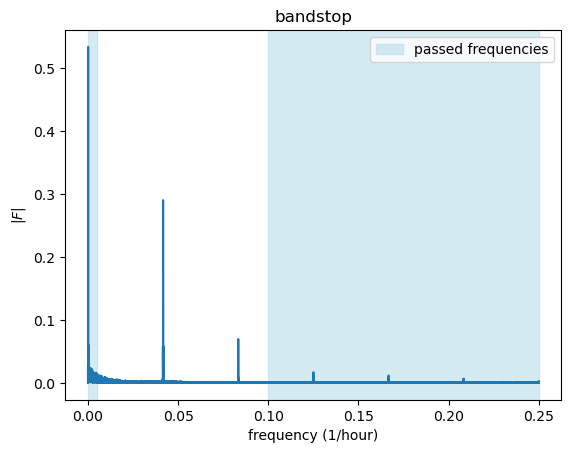

In [17]:
low_thresh = 0.005
high_thresh = 0.1

fig, ax = plt.subplots()
ax.plot(k, fft_abs)
ax.set(xlabel="frequency (1/hour)",
       ylabel=r"$|F|$",
       title=r"bandstop")

ax.axvspan(0, low_thresh, color='lightblue', alpha=0.5)
ax.axvspan(high_thresh, np.max(k), color='lightblue', alpha=0.5, label='passed frequencies')
ax.legend()

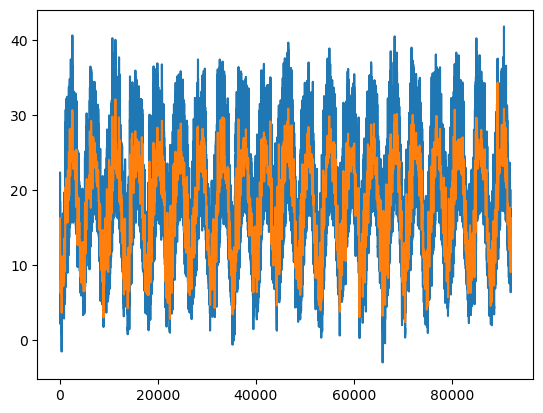

In [18]:
fig, ax = plt.subplots()
ax.plot(x)
condition = ~(np.abs(freq) > low_thresh) & (np.abs(freq) < high_thresh)
ax.plot(fft_filter(x, condition))

By applying a bandstop filter we keep the low frequency signal of the yearly oscillation, and the high frequency noise, but we remove the daily signal by removing the band that corresponds with daily oscillation.